## Importações

In [ ]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import seaborn as sns
import matplotlib.pyplot as plt


## Leitura

In [ ]:
spark = SparkSession.builder \
    .appName("AnaliseENEM") \
    .config("spark.driver.memory", "2g") \
    .getOrCreate()

leitura = spark.read.option("header", "true") \
               .option("sep", ";") \
               .option("encoding", "ISO-8859-1") \
               .option("inferSchema", "true") \
               .csv("data_raw/MICRODADOS_ENEM_2021.csv")


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
26/01/19 22:37:59 WARN Utils: Your hostname, DESKTOP-NR380U6, resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
26/01/19 22:37:59 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/19 22:38:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Verificação da qualidade dos dados na camada bronze:

###  1. Escolha estados

Tendo em vista o tamanho exagerado da base de dados por decisão do grupo em união com o professor foi tomada a decisão de trazer dados para escolher um estado para fazer análise, os gráficos nessa primiera parte estão de acordo com essa proposta.

#### 1.1 Gráfico de pizza de estados com mais incritos e mais colunas preenchidas

26/01/19 22:38:11 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


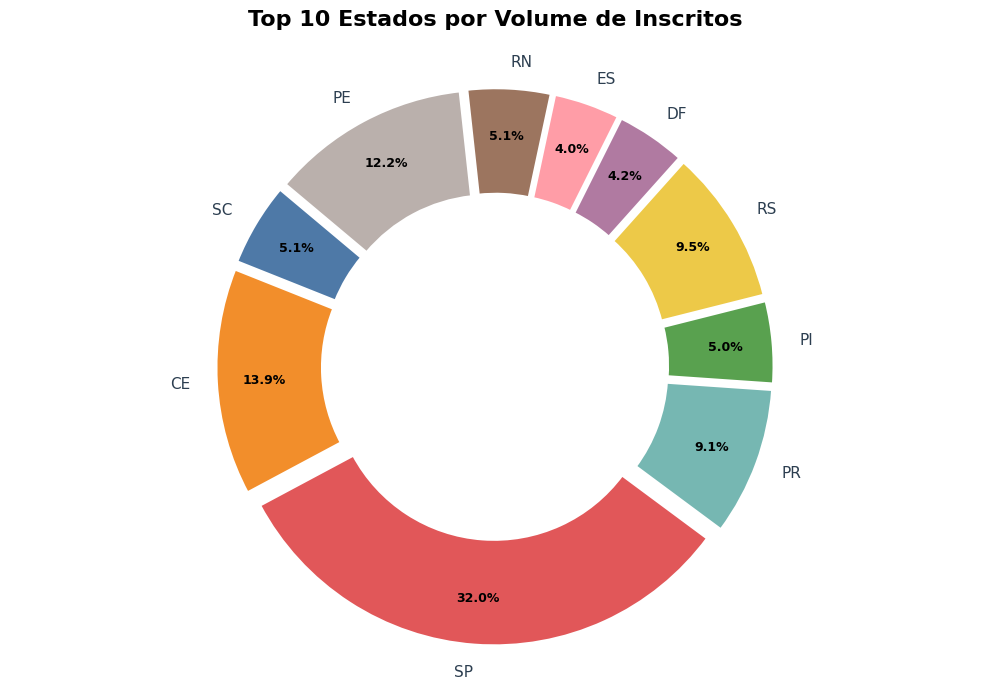

In [5]:
coluna_uf = 'SG_UF_PROVA' 

colunas_analise = [c for c in leitura.columns if c != coluna_uf]
total_colunas = len(colunas_analise)
verificacao_UF = leitura.groupBy(coluna_uf).agg(
    F.count("*").alias("Qtd_Inscritos"),
    *[F.count(c).alias(c) for c in colunas_analise]
)
analise_final = verificacao_UF.withColumn(
    "Total_Celulas_Preenchidas", 
    sum(F.col(c) for c in colunas_analise)
).withColumn(
    "Perc_Preenchimento",
    F.round((F.col("Total_Celulas_Preenchidas") / (F.col("Qtd_Inscritos") * total_colunas)) * 100, 2)
)
relatorio_estados = analise_final.select(
    F.col(coluna_uf).alias("Estado"), 
    F.col("Qtd_Inscritos").alias("Inscritos"), 
    F.col("Perc_Preenchimento").alias("% Preenchido")
).orderBy(F.desc("% Preenchido"))

dados_locais = relatorio_estados.limit(10).collect()

estados = [row['Estado'] for row in dados_locais]
inscritos = [row['Inscritos'] for row in dados_locais]

cores = ['#4E79A7', '#F28E2B', '#E15759', '#76B7B2', '#59A14F', 
         '#EDC948', '#B07AA1', '#FF9DA7', '#9C755F', '#BAB0AC']

fig, ax = plt.subplots(figsize=(10, 7))

fatias, textos, porcentagens = ax.pie(
    inscritos, 
    labels=estados, 
    autopct='%1.1f%%', 
    startangle=140, 
    colors=cores,
    pctdistance=0.82, 
    explode=[0.05] * len(estados), 
    wedgeprops={'width': 0.4, 'edgecolor': 'white', 'linewidth': 2}
)

plt.setp(porcentagens, size=9, weight="bold")
plt.setp(textos, size=11, color="#2c3e50")

ax.set_title('Top 10 Estados por Volume de Inscritos', fontsize=16, pad=25, weight='bold')
ax.axis('equal')  

plt.tight_layout()
plt.show()

##### Explicação
A análise apresentada seguiu um refinamento em duas etapas. Inicialmente, filtramos os 10 estados com as maiores taxas de preenchimento de dados. Como a variação de completude entre esses estados foi mínima (margem de apenas 1%), cruzamos esse ranking com a representatividade populacional para definir o foco do estudo. O gráfico de rosca revela que São Paulo detém 32% dos inscritos deste grupo de elite, consolidando-se como o objeto de estudo ideal por aliar integridade de dados e expressividade estatística.

#### 1.2 Gráfico de colunas menos preenchidas entre os melhores estados

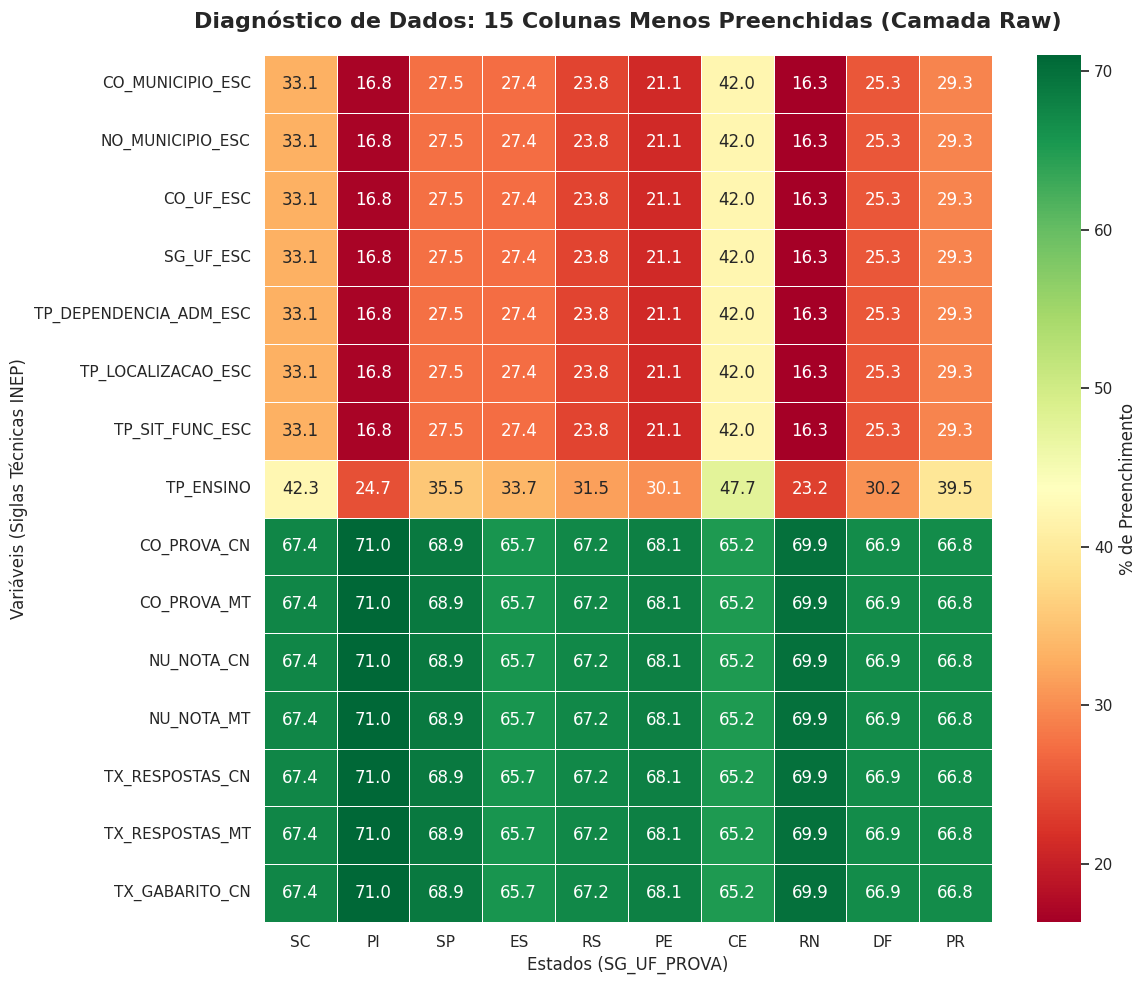

In [6]:
melhores_estados = [row['Estado'] for row in relatorio_estados.limit(10).collect()]
filtro_melhores_estados = leitura.filter(F.col("SG_UF_PROVA").isin(melhores_estados))

caminho_dicionario = 'data_raw/Dicionário_Microdados_Enem_2021.xlsx - MICRODADOS_ENEM_2021.csv'

coluna_dados = [c for c in leitura.columns if c != "SG_UF_PROVA"]
contagem_colunas = [F.count(c).alias(c) for c in coluna_dados]

analise_colunas = filtro_melhores_estados.groupBy("SG_UF_PROVA").agg(
    F.count('*').alias("Total_inscritos"),
    *contagem_colunas
)

colunas_pandas = analise_colunas.toPandas().set_index("SG_UF_PROVA")

for col in coluna_dados:
    colunas_pandas[col] = (colunas_pandas[col] / colunas_pandas["Total_inscritos"]) * 100

piores_colunas = colunas_pandas[coluna_dados].mean().nsmallest(15).index.tolist()

plot_piores_colunas = colunas_pandas[piores_colunas].T

plt.figure(figsize=(12, 10))
sns.set_theme(style="white")

ax = sns.heatmap(
    plot_piores_colunas, 
    annot=True, 
    fmt=".1f", 
    cmap="RdYlGn", 
    linewidths=.5,
    cbar_kws={'label': '% de Preenchimento'}
)

plt.title('Diagnóstico de Dados: 15 Colunas Menos Preenchidas (Camada Raw)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Estados (SG_UF_PROVA)', fontsize=12)
plt.ylabel('Variáveis (Siglas Técnicas INEP)', fontsize=12)

plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

##### Explicação
Após delimitarmos os estados com maior potencial, aplicamos um diagnóstico de estresse focado nas vulnerabilidades da Camada Raw. Identificamos as 15 variáveis com os menores índices de preenchimento para validar se as lacunas eram generalizadas ou específicas de certas regiões. O Mapa de Calor revela que, mesmo nas colunas mais críticas, o comportamento de São Paulo e dos demais estados selecionados é consistente. Essa análise é fundamental para o processo de feature selection, permitindo-nos decidir, logo no início do pipeline, quais colunas devem ser descartadas ou submetidas a processos de imputação devido à baixa densidade de dados.

### 2. Análise de dados do estado escolhido

#### 2.1 Linhas preenchidas por coluna 

/tmp/ipykernel_1939/3959303540.py:17: FutureWarning:                            

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(valores_plot), y=list(colunas_plot), palette="viridis")


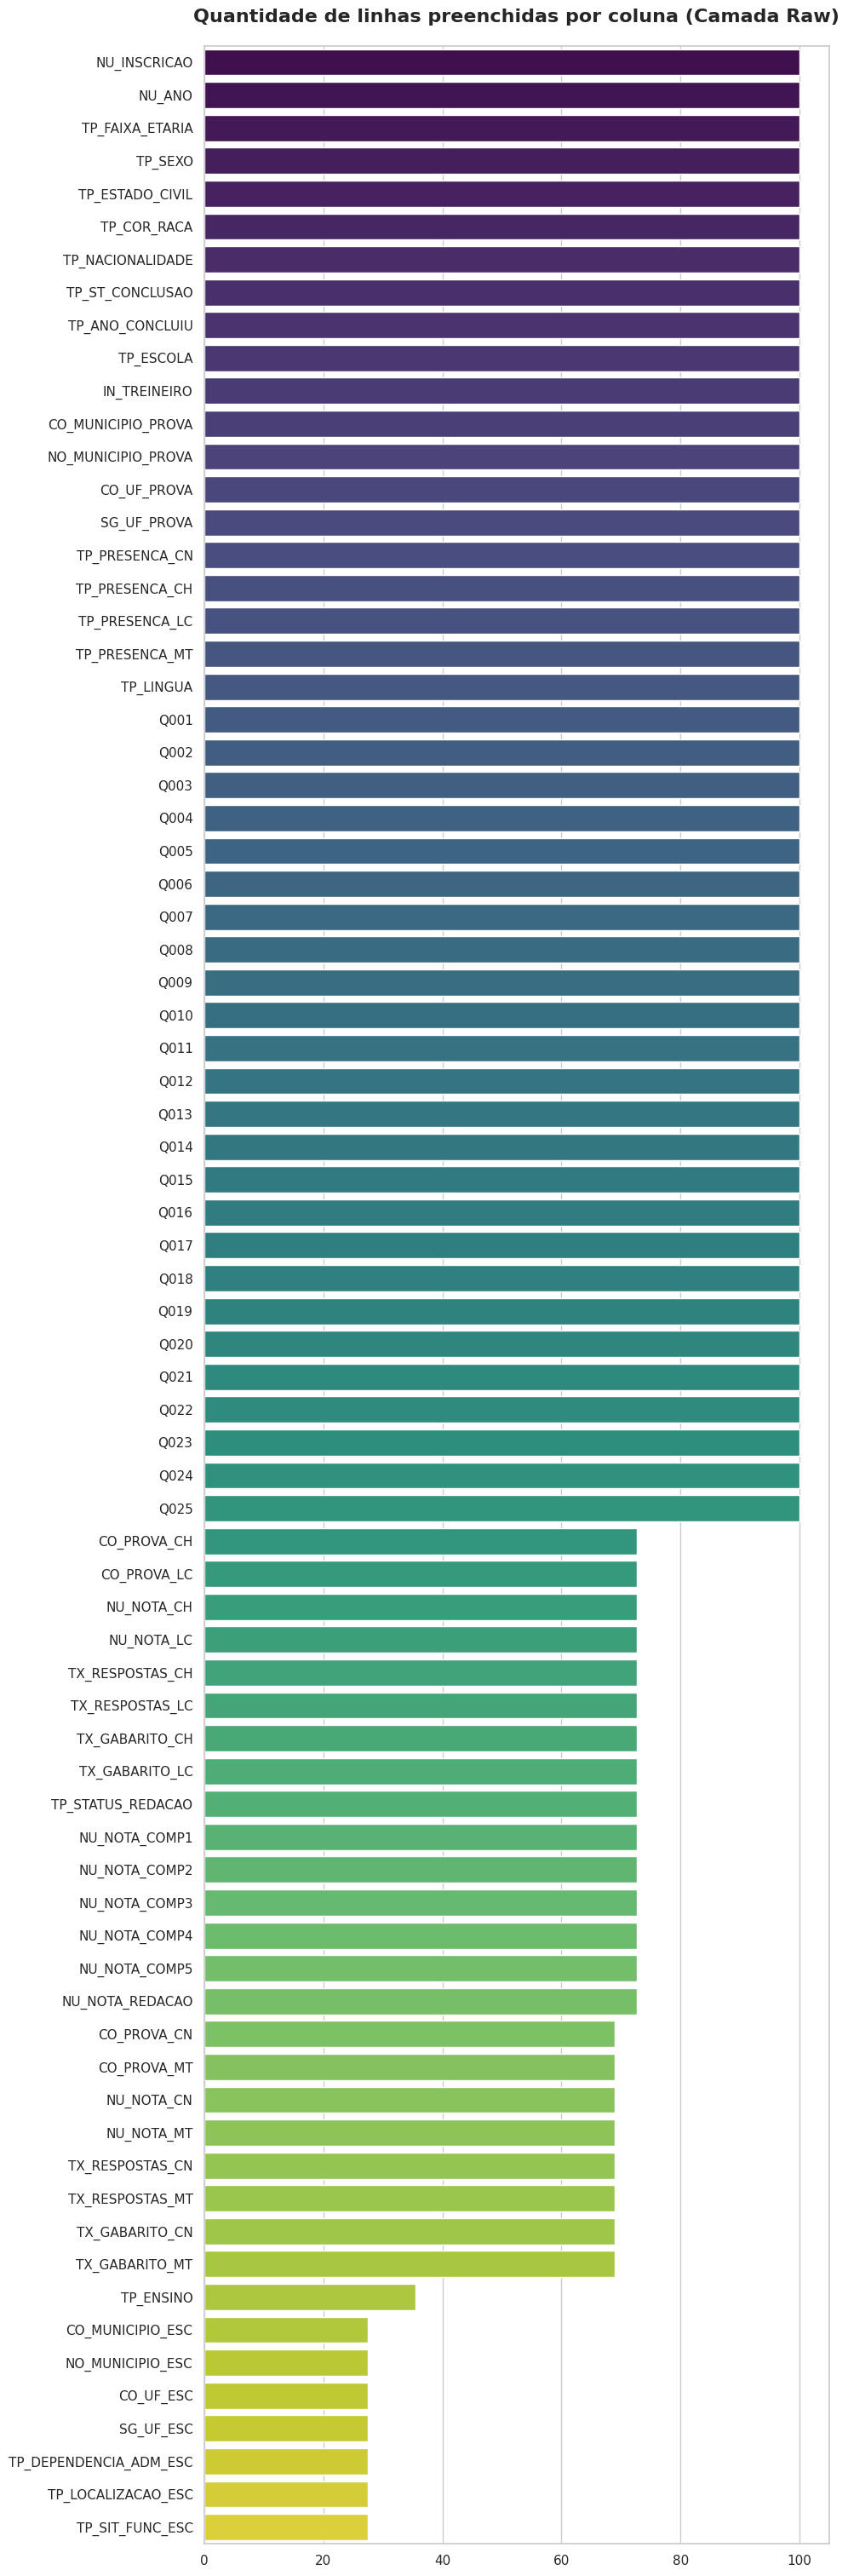

In [7]:
estado_SP = leitura.filter(F.col("SG_UF_PROVA") == "SP")

total_sp = estado_SP.count()

total_sp_nulos = estado_SP.agg(*[F.count(F.col(c)).alias(c) for c in estado_SP.columns]).collect()[0].asDict()

coluna_total_nulos = list(total_sp_nulos.keys())
percentual_coluna_nula = [(total_sp_nulos[c]/total_sp) * 100 for c in coluna_total_nulos]

dados_ordenados_completude = sorted(zip(coluna_total_nulos, percentual_coluna_nula), key=lambda x: x[1], reverse=True)

colunas_plot, valores_plot = zip(*dados_ordenados_completude)

plt.figure(figsize=(10, len(colunas_plot) * 0.4))
sns.set_theme(style="whitegrid")

sns.barplot(x=list(valores_plot), y=list(colunas_plot), palette="viridis")

plt.title('Quantidade de linhas preenchidas por coluna (Camada Raw)', fontsize=16, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()


##### Explicação

Com a amostra de São Paulo consolidada como o foco da pesquisa, iniciamos o Data Profiling exaustivo da unidade federativa. Esta análise de completude por coluna é o critério final de viabilidade técnica: ela mapeia quais variáveis possuem densidade suficiente para análises estatísticas confiáveis e quais apresentam vacuolização de dados (altas taxas de nulidade). Ao visualizarmos, estabelecemos um corte de qualidade, isolando as variáveis que comporão o núcleo da nossa modelagem e identificando lacunas que exigirão tratamentos específicos de Data Cleaning na hora de passar para camada silver. 

#### 2.2 Linhas duplicadas 

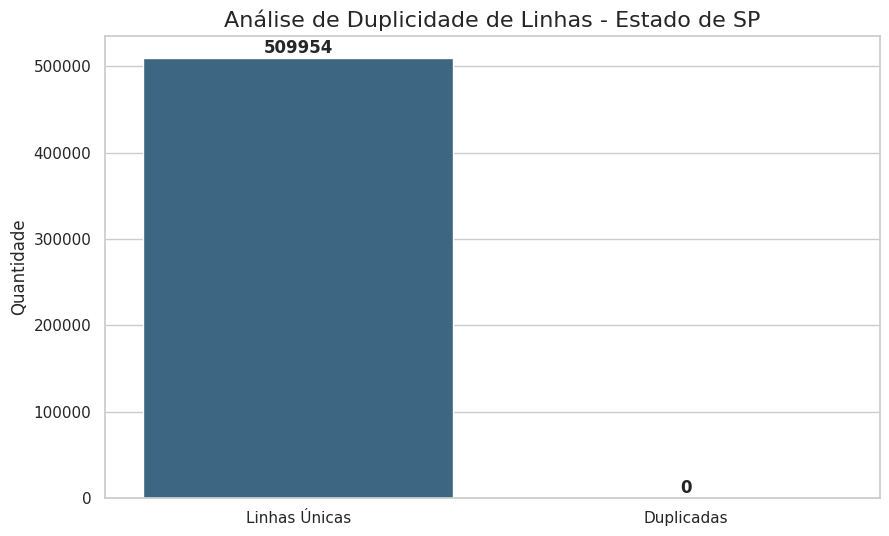

In [ ]:
total_linhas = estado_SP.count()
total_linhas_unicas = estado_SP.distinct().count()
total_duplicados = total_linhas - total_linhas_unicas

categorias = ['Linhas Únicas', 'Duplicadas']
valores = [total_linhas_unicas, total_duplicados]

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=categorias, y=valores, hue=categorias, palette='viridis', legend=False)

for i, v in enumerate(valores):
    ax.text(i, v + (max(valores)*0.01), str(v), ha='center', fontweight='bold')

plt.title('Análise de Duplicidade de Linhas - Estado de SP', fontsize=16)
plt.ylabel('Quantidade')
plt.show()

##### Explicação


#### 2.3 Análise de Outliers nas notas do ENEM

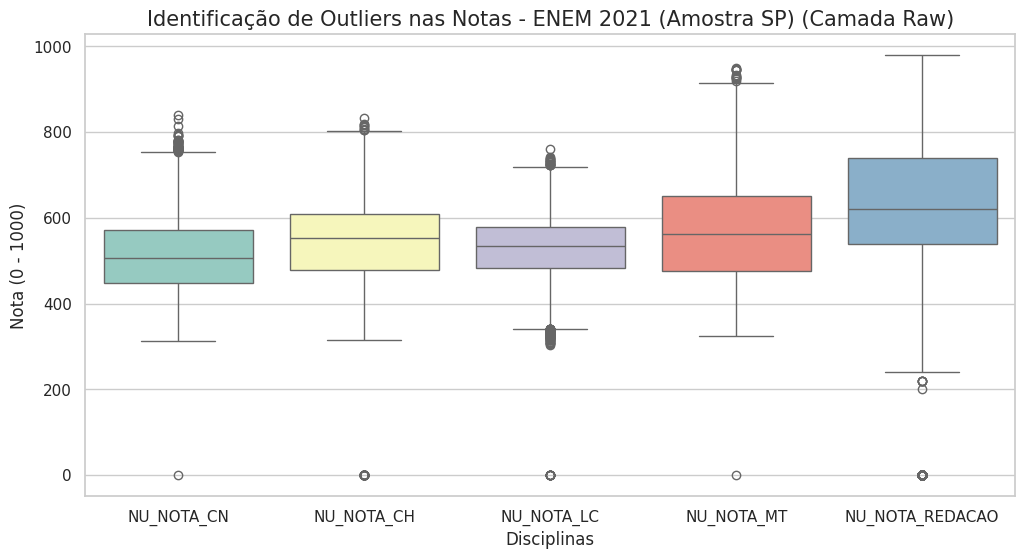

In [9]:
coluna_notas = ["NU_NOTA_CN", "NU_NOTA_CH", "NU_NOTA_LC", "NU_NOTA_MT", "NU_NOTA_REDACAO"]
resumo_notas = estado_SP.select(coluna_notas).describe()

grafico_outlier = estado_SP.select(coluna_notas).sample(False, 0.05).toPandas()

plt.figure(figsize=(12, 6))
sns.set_theme(style="whitegrid")

sns.boxplot(data=grafico_outlier, palette="Set3")

plt.title('Identificação de Outliers nas Notas - ENEM 2021 (Amostra SP) (Camada Raw)', fontsize=15)
plt.ylabel('Nota (0 - 1000)')
plt.xlabel('Disciplinas')
plt.show()

#### 2.4 Rating e dispersão

/tmp/ipykernel_1939/2143020556.py:16: FutureWarning:                            

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=status_rating, x='RATING', y='count', palette='viridis')
/tmp/ipykernel_1939/2143020556.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=status_rating, x='RATING', y='count', palette='viridis')


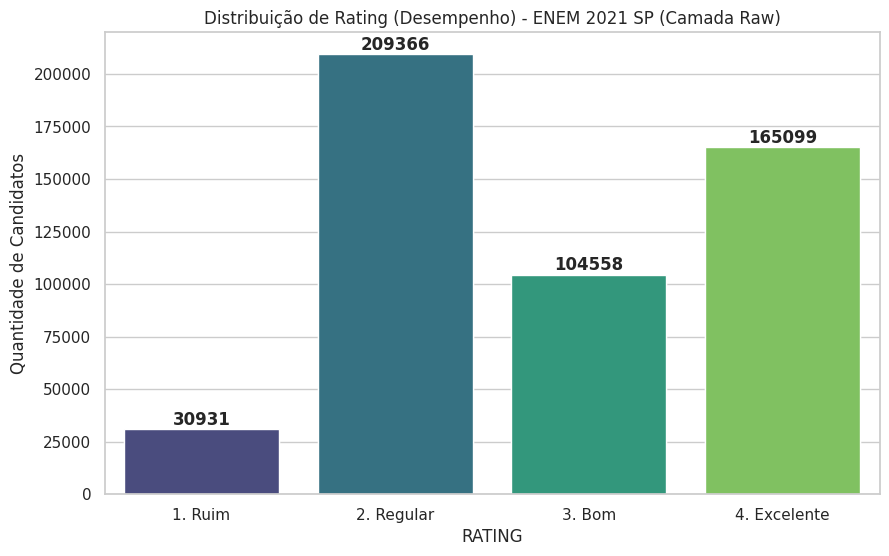

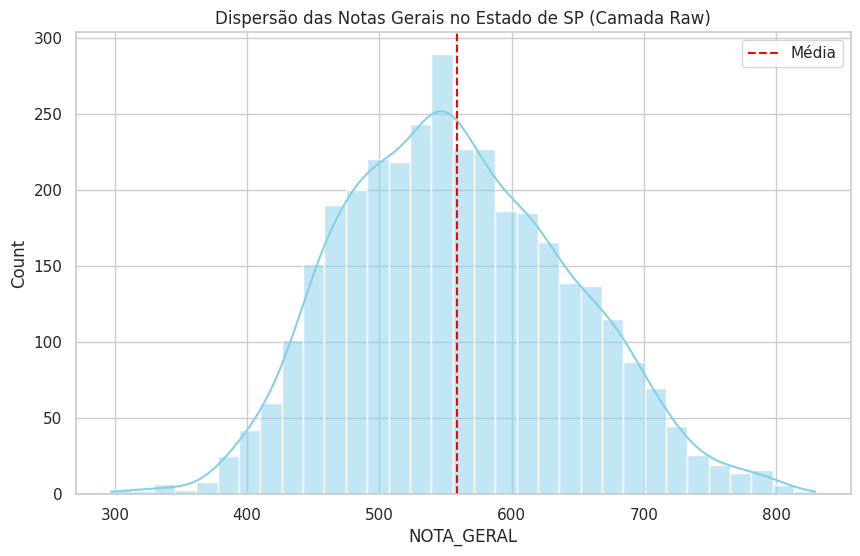

In [35]:
media_SP_notas = estado_SP.withColumn("NOTA_GERAL", sum([F.col(c) for c in coluna_notas]) / 5)

media_SP_notas = media_SP_notas.withColumn("RATING",
    F.when(F.col("NOTA_GERAL") < 450, "1. Ruim")
     .when(F.col("NOTA_GERAL") < 600, "2. Regular")
     .when(F.col("NOTA_GERAL") < 750, "3. Bom")
     .otherwise("4. Excelente")
)

status_dispersao = media_SP_notas.select("NOTA_GERAL").summary("mean", "stddev", "min", "25%", "50%", "75%", "max")

status_rating = media_SP_notas.groupBy("RATING").count().orderBy("RATING").toPandas()

plt.figure(figsize=(10, 6))

ax = sns.barplot(data=status_rating, x='RATING', y='count', palette='viridis')

valores = status_rating['count'].values

for i, v in enumerate(valores):
    ax.text(i, v + (max(valores) * 0.01), str(int(v)), ha='center', fontweight='bold')

sns.barplot(data=status_rating, x='RATING', y='count', palette='viridis')
plt.title('Distribuição de Rating (Desempenho) - ENEM 2021 SP (Camada Raw)')
plt.ylabel('Quantidade de Candidatos')
plt.show()

amostra_notas = media_SP_notas.select("NOTA_GERAL").sample(False, 0.01).toPandas()

plt.figure(figsize=(10, 6))
sns.histplot(amostra_notas['NOTA_GERAL'], kde=True, color='skyblue')
plt.axvline(amostra_notas['NOTA_GERAL'].mean(), color='red', linestyle='--', label='Média')
plt.title('Dispersão das Notas Gerais no Estado de SP (Camada Raw)')
plt.legend()
plt.show()

#### 2.5 Outlier da idade dos estudantes do ENEM

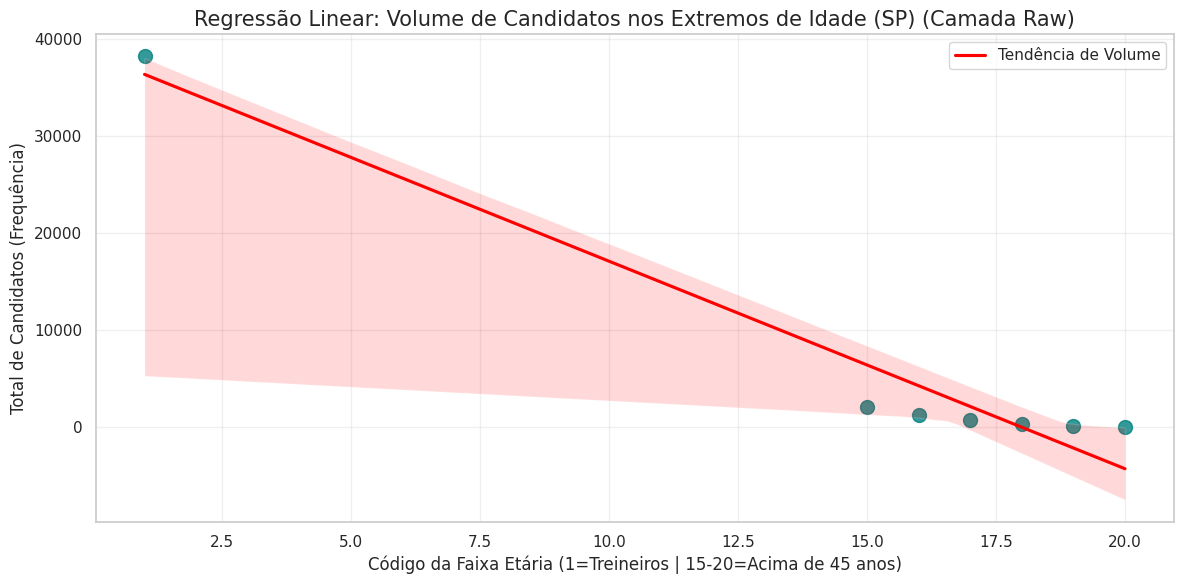

In [11]:
faixa_etaria_estudantes = leitura.filter(F.col("SG_UF_PROVA") == "SP") \
    .select("TP_FAIXA_ETARIA", "NU_NOTA_CN", "NU_NOTA_CH", "NU_NOTA_LC", "NU_NOTA_MT", "NU_NOTA_REDACAO") \
    .dropna()

outlier_idade = faixa_etaria_estudantes.filter((F.col("TP_FAIXA_ETARIA") == 1) | (F.col("TP_FAIXA_ETARIA") >= 15))

distribuicao_extremos = outlier_idade.groupBy("TP_FAIXA_ETARIA").count().orderBy("TP_FAIXA_ETARIA").toPandas()

plt.figure(figsize=(12, 6))

sns.regplot(
    data=distribuicao_extremos, 
    x="TP_FAIXA_ETARIA", 
    y="count", 
    color="teal",
    line_kws={"color": "red", "label": "Tendência de Volume"},
    scatter_kws={"s": 100}
)

plt.title('Regressão Linear: Volume de Candidatos nos Extremos de Idade (SP) (Camada Raw)', fontsize=15)
plt.xlabel('Código da Faixa Etária (1=Treineiros | 15-20=Acima de 45 anos)', fontsize=12)
plt.ylabel('Total de Candidatos (Frequência)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

#### 2.6 Análise completude dados escola X participantes do ano de formação 

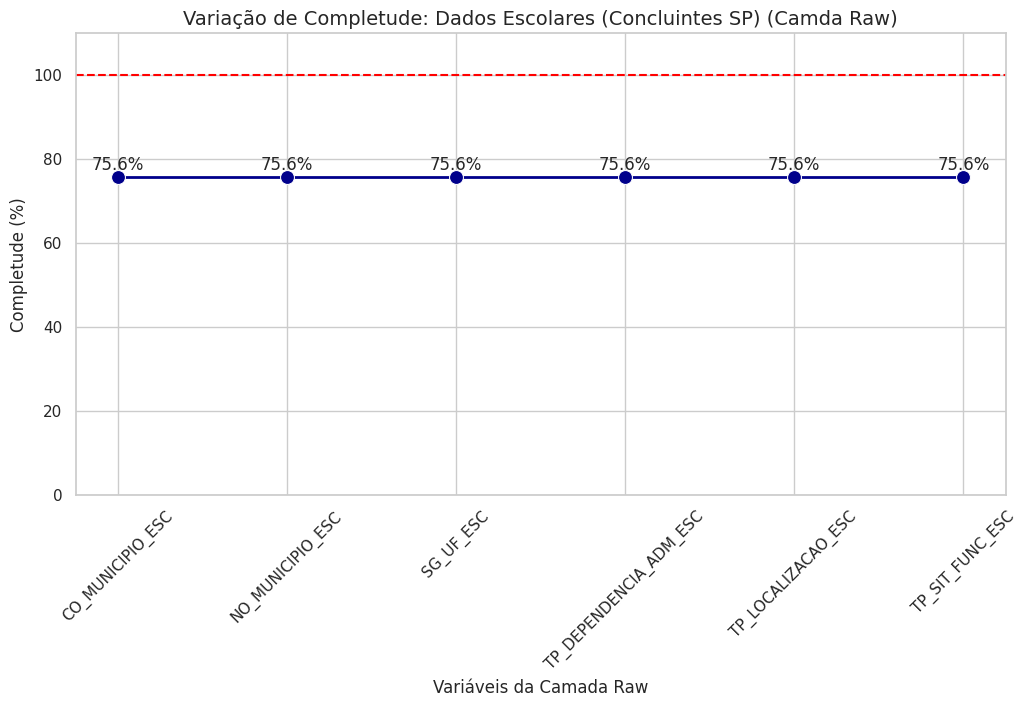

In [26]:
formandos_SP = estado_SP.filter(F.col("TP_ST_CONCLUSAO") == 2)

colunas_escola = [
    'CO_MUNICIPIO_ESC', 'NO_MUNICIPIO_ESC', 'SG_UF_ESC', 
    'TP_DEPENDENCIA_ADM_ESC', 'TP_LOCALIZACAO_ESC', 'TP_SIT_FUNC_ESC'
]

contagem_formandos = formandos_SP.count()

expressoes = [(F.count(c) / contagem_formandos * 100).alias(c) for c in colunas_escola]

plot_formandos_escolas = formandos_SP.select(expressoes).toPandas().melt()
plot_formandos_escolas.columns = ['Coluna', 'Percentual']
plot_formandos_escolas = plot_formandos_escolas.sort_values('Percentual', ascending=False)

plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

sns.lineplot(data=plot_formandos_escolas, x='Coluna', y='Percentual', marker='o', markersize=10, linewidth=2, color='darkblue')

for i in range(plot_formandos_escolas.shape[0]):
    plt.text(i, plot_formandos_escolas.Percentual.iloc[i] + 2, 
             f"{plot_formandos_escolas.Percentual.iloc[i]:.1f}%", ha='center')

plt.title('Variação de Completude: Dados Escolares (Concluintes SP) (Camda Raw)', fontsize=14)
plt.ylabel('Completude (%)')
plt.xlabel('Variáveis da Camada Raw')
plt.ylim(0, 110)
plt.xticks(rotation=45)
plt.axhline(y=100, color='red', linestyle='--', label='Meta Ideal (100%)')

plt.show()